#UNET 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

 set the seed value of the NumPy and TensorFlow. Seeding helps to set the randomness of the environment and also helps to make the results reproducible

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

hyperparameters that are used while training the UNet architecture

In [11]:
IMAGE_SIZE = 384
PATH = "C:/Users/Honey/Desktop/DigiPath/"

This function loads the images and masks, split them into training, validation and testing dataset using 80-10-10 ratio.

In [12]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "segmentations/*")))
    
    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

In [13]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("val data: ", len(valid_x))

Training data:  108
val data:  12


In [14]:
IMAGE_SIZE = 384

In [15]:
def read_image(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE,IMAGE_SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE,IMAGE_SIZE))
    x[x==255]=1 # blue: class label: 1
    x[x==125]=2 # brown: class label: 2
    x = x.astype(np.int32)
    return x

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])

    return image, mask

SIMPLE UNET FOR MULTICLASS


In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

IMAGE_SIZE = 384

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

model = build_unet((IMAGE_SIZE, IMAGE_SIZE, 3), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 activation_8 (Activation)      (None, 24, 24, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 24, 24, 128)  147456      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 24, 24, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 24, 24, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 up_sampli

                                                                                                  
 activation_16 (Activation)     (None, 384, 384, 16  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 384, 384, 16  2304        ['activation_16[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 384, 384, 16  64         ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

TRAINING UNET

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Dataset """
(train_x, train_y), (valid_x, valid_y)= load_data(PATH,split=0.2)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)}")

""" Hyperparameters """
shape = (384, 384, 3)
num_classes = 3
lr = 3e-4
batch_size = 2
epochs = 50

""" Model """
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-8),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks,
    validation_freq=1
)

Dataset: Train: 96 - Valid: 24
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.4252
Epoch 1: saving model to model.h5
48/48 [==============================] - 38s 612ms/step - loss: 0.4252 - val_loss: 0.8173 - lr: 3.0000e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.2960
Epoch 2: saving model to model.h5
48/48 [==============================] - 30s 629ms/step - loss: 0.2960 - val_loss: 0.5875 - lr: 3.0000e-04
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2456
Epoch 3: saving model to model.h5
48/48 [==============================] - 31s 636ms/step - loss: 0.2456 - val_loss: 0.5373 - lr: 3.0000e-04
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.2217
Epoch 4: saving model to model.h5
48/48 [==============================] - 31s 645ms/step - loss: 0.2217 - val_loss: 0.5866 - lr: 3.0000e-04
Epoch 5/50
48/48 [==============================] - ETA: 0s - loss: 0.1973
Epoch 5: saving model to model

In [23]:
# random prediction!
p = 'C:/Users/Honey/Desktop/DigiPath/images/48_67.png'
gt = 'C:/Users/Honey/Desktop/DigiPath/segmentations/48_67.png'
im = read_image(p)
gt = read_mask(gt)

x = np.expand_dims(im,0)
x.shape

(1, 384, 384, 3)

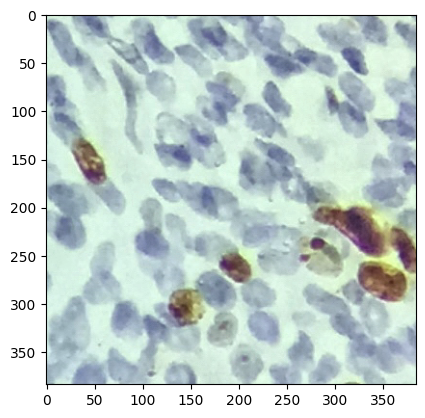

In [ ]:
plt.imshow(im)

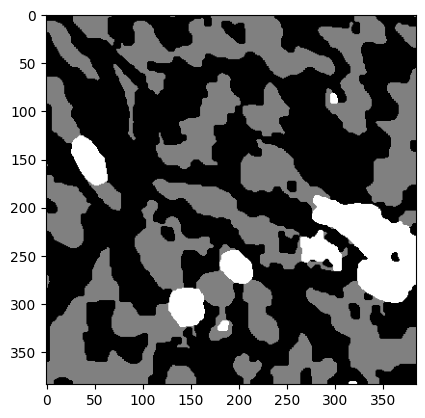

In [ ]:
plt.imshow(gt,cmap='gray')

In [ ]:
preds = model.predict(x)
preds = preds[0,:,:,:] # (batch_size=1, 384,384,3) -> (384,384,3)

1/1 [==============================] - 0s 21ms/step


In [ ]:
np.unique(preds)

array([3.687735e-04, 3.698865e-04, 3.724048e-04, ..., 9.686157e-01,
       9.714441e-01, 9.716471e-01], dtype=float32)

In [ ]:
def get_segmentation_map(prediction):
    # Step 1: Get the class index
    class_indices = np.argmax(preds, axis=-1)

    # Step 2: Reshape the index array
    reshaped_indices = class_indices.reshape((class_indices.shape[0], class_indices.shape[1]))

    # Step 3: Create the segmentation map
    segmentation_map = np.zeros_like(reshaped_indices, dtype=np.uint8)
    for class_label in np.unique(reshaped_indices):
        segmentation_map[reshaped_indices == class_label] = class_label

    print('unique:',np.unique(segmentation_map))

    return segmentation_map

unique: [0 1 2]


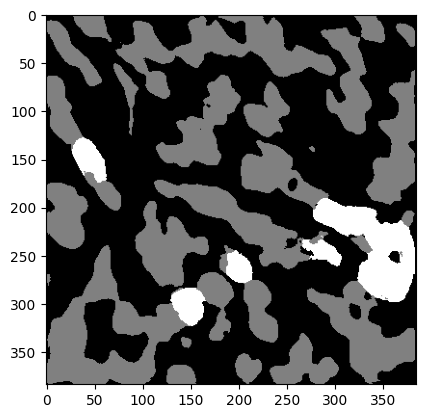

In [ ]:
plt.imshow(get_segmentation_map(preds),cmap='gray')

unique: [0 1 2]


Text(0.5, 1.0, 'PREDICTED MASK')

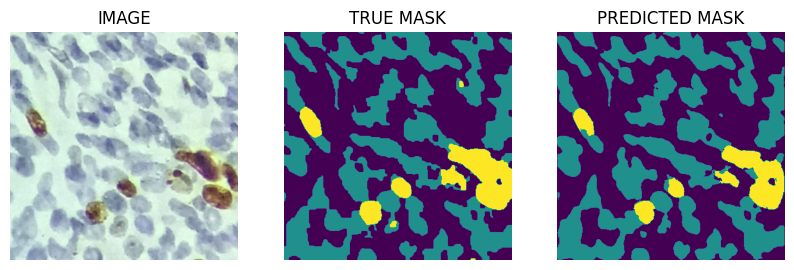

In [ ]:
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im)
plt.axis('off')
plt.title("IMAGE")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(gt)
plt.axis('off')
plt.title("TRUE MASK")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(get_segmentation_map(preds))
plt.axis('off')
plt.title("PREDICTED MASK")
  
